# 기차 대차 이상 소음원 위치 판별 모델

In [184]:
# Author jhCOR

### 드라이브 마운트 /  라이브러리 임포트 / 라이브러리 설치

In [185]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
import torchaudio.functional as F
import torch.nn as nn
import torchaudio
import torch

import pandas as pd
import numpy as np
import librosa
import glob
import os
import re
from tqdm import tqdm
import random
import copy

import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import torch.optim as optim
from torch.utils.data import Dataset
from collections.abc import Iterable
from torch.utils.data import DataLoader, random_split

from torchvision.models import resnet18

### 시드 고정 / device설정 / 실험 세팅 값 설정

In [187]:
print("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    print('Current cuda device:', torch.cuda.current_device())
    print('Count of using GPUs:', torch.cuda.device_count())

#################

config = {'sr' : 25600, 'device':device, 'n_mels':80, 'core':os.cpu_count(), "train_ratio":0.6,
           "valid_ratio":0.2, "test_ratio":0.2, "path":"./best_model.pt", "seed": 44}

#################

dirPath = "/content/drive/MyDrive/Artificial_Intelligence/ai_data/기차대차소음/S206_wav"
csvPath = "/content/drive/MyDrive/Artificial_Intelligence/ai_data/기차대차소음/metadata.csv"
othersourcePath = "/content/drive/MyDrive/Artificial_Intelligence/ai_data/MTAT_SMALL"


cpu


In [188]:
def restrict_seed(seed):
    print("시드 고정: ", seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def isIterable(target):
    return True if isinstance(target, Iterable) else False

In [189]:
restrict_seed(config['seed'])
print(config)

시드 고정:  44
{'sr': 25600, 'device': 'cpu', 'n_mels': 80, 'core': 2, 'train_ratio': 0.6, 'valid_ratio': 0.2, 'test_ratio': 0.2, 'path': './best_model.pt', 'seed': 44}


### 데이터셋 정의

In [231]:
class soundDataset(Dataset):
    def __init__(self, dir_path, csv_path, mode="train", config=None, other_sound_path=None, mixSoundRatio=0):
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=config['sr'], n_mels=config['n_mels'])
        self.db_converter = torchaudio.transforms.AmplitudeToDB()
        self.dir = dir_path
        self.mixSoundRatio = mixSoundRatio
        self.config = config

        assert other_sound_path is not None, "it must be filled"
        self.other_sound_dir = other_sound_path

        colume_list = ['Car_type', 'Horn', 'Position', 'S206_position','Length', 'channel97_start', 'channel97_end', 'peak', 'Car_num', 'path']

        metaData = pd.read_csv(csv_path)
        metaData = metaData[colume_list]
        metaData = metaData.sort_values(by="Car_type")
        metaData = metaData.iloc[1:]
        metaData['car_type_index'] = metaData['Car_type'].apply(lambda x: 1 if x == "수소열차" else 0)
        metaData['label'] = metaData['Horn'].apply(lambda x: 1 if x == "Yes" else 0)
        metaData['Position'] = metaData['Position'].fillna(-1)

        self.meta = metaData[metaData['Horn']=="Yes"]
        self.meta = self._check_all_file_exist()
        self.meta.loc[:, 'length'] = self._check_all_file_size()

        self.meta.loc[:, 'average_velocity(km)'] = ( self.meta['Length'] * 0.001)  / ( ( self.meta['channel97_end'] - self.meta['channel97_start'] ) / 3600)
        self.meta.loc[:, 'average_velocity(m/s)'] = ( self.meta['Length'] )  / ( ( self.meta['channel97_end'] - self.meta['channel97_start'] ) )
        self.meta.loc[(self.meta['Car_type']=='수소열차') & (self.meta['average_velocity(km)']>80), 'average_velocity(km)'] = 80
        self.meta.loc[ (self.meta['Car_type']=='차세대전동차') & (self.meta['average_velocity(km)']>70), 'average_velocity(km)'] = 70

        self.meta.loc[:, 'calculation'] = ( self.meta['peak'] - self.meta['channel97_start']) * ( self.meta['average_velocity(m/s)']) - 22
        self.meta['calculation'] = self.meta['calculation'].apply(lambda x: 0 if x < 0 else x)
        self.meta = self.meta[ self.meta['calculation']>0]
        print("Horn Yes 개수", len(self.meta[self.meta['Horn']=="Yes" ]), "Horn No 개수", len(self.meta[self.meta['Horn']=="No" ]))

    def _get_other_sound(self):
    # 병합할 다른 소리 파일 가져오기
        _meta = pd.read_csv( self.other_sound_dir + "/meta.csv", index_col=[0] )

        _meta = _meta['mp3_path']
        path = _meta.iloc[random.randrange(1,len(_meta))]

        waveform, sample_rate = torchaudio.load( self.other_sound_dir / Path(str(path)).with_suffix('.mp3'))
        audio_sample = F.resample(waveform[0], sample_rate, self.config['sr'], lowpass_filter_width=6)
        return audio_sample

    def _check_all_file_exist(self):
    # 파일-음원 매칭을 체크하여 소리 파일이 없는 경우 제외
        for i in range(len(self.meta['path'])):
            path = self.meta['path'].iloc[i]
            if not os.path.exists(self.dir / Path(path).with_suffix('.wav')):
                meata_data = self.meta [self.meta['path']!=path]
                return meata_data

    def _check_all_file_size(self):

        length_list = []
        for i in range(len(self.meta['path'])):
            waveform, sample_rate = torchaudio.load(self.dir / Path(self.meta['path'].iloc[i]).with_suffix('.wav'))
            audio_sample = F.resample(waveform[0], sample_rate, self.config['sr'], lowpass_filter_width=6)

            length_list.append(len(audio_sample))
        return length_list

    def minmaxScaler(self, data):
    # 정규화 수행
        data_min, data_max = data.min(), data.max()
        new_lower, new_upper = -1, 1
        scaled_data = (data - data_min)/(data_max - data_min)*(new_upper - new_lower) + new_lower
        return scaled_data

    def mixOtherSound(self, audio_sample, mix_rate=1.0):
    # 시험 데이터를 실 데이터로 전이시키는 함수
        other_sound = self._get_other_sound()
        if len(other_sound) > len(audio_sample):
            other_sound = other_sound[:len(audio_sample)]
        else:
            other_sound = other_sound[:len(audio_sample)]
            front = int( (len(audio_sample) - len(other_sound)) / 4 )
            back = (len(audio_sample) - len(other_sound)) - front
            other_sound = nn.functional.pad(other_sound, (front, back) , 'constant', value=0)

        scaled_audio_data = self.minmaxScaler(audio_sample)
        scaled_other_data = self.minmaxScaler(other_sound)

        audio_sample = scaled_audio_data + (scaled_other_data*mix_rate)

        return audio_sample

    def __getitem__(self, idx):
        row =  self.meta.iloc[idx]
        path = row['path']
        label = row['label']

        waveform, sample_rate = torchaudio.load(self.dir / Path(path).with_suffix('.wav'))
        audio_sample = F.resample(waveform[0], sample_rate, self.config['sr'], lowpass_filter_width=6)

        if self.mixSoundRatio > 0:
            audio_sample = self.mixOtherSound(audio_sample, mix_rate=self.mixSoundRatio)

        feature = self.db_converter(self.mel_converter(audio_sample))
        label = nn.functional.one_hot(torch.tensor(label), num_classes=2)

        return feature, label

    def __len__(self):
        return len(self.meta)

    def getdata(self):
        return self.meta

In [232]:
sound_dataset = soundDataset(dirPath, csvPath, config=config, other_sound_path=othersourcePath, mixSoundRatio=0)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Horn Yes 개수 47 Horn No 개수 0


In [233]:
dataframe = sound_dataset.getdata()
dataframe

,Car_type,Horn,Position,S206_position,Length,channel97_start,channel97_end,peak,Car_num,path,car_type_index,label,length,average_velocity(km),average_velocity(m/s),calculation
59,수소열차,Yes,22.0,22,44,11.2,13.2,13.107461,2,221109_hydrogen_S206_Num_1_Horn_Yes_2_22.wav,1,1,719262,79.200000,22.000000,19.964141
61,수소열차,Yes,22.0,22,44,11.4,13.4,13.301406,2,221109_hydrogen_S206_Num_3_Horn_Yes_2_22.wav,1,1,684785,79.200000,22.000000,19.830937
15,수소열차,Yes,22.0,22,44,19.2,21.2,20.925391,2,221102_hydrogen_S206_Num_15_Horn_Yes_2_22.wav,1,1,806049,79.200000,22.000000,15.958594
1,수소열차,Yes,22.0,22,44,7.8,9.0,8.785937,2,221102_hydrogen_S206_Num_1_Horn_Yes_2_22.wav,1,1,449390,80.000000,36.666667,14.151042
3,수소열차,Yes,22.0,22,44,11.4,12.6,12.374844,2,221102_hydrogen_S206_Num_3_Horn_Yes_2_22.wav,1,1,638419,80.000000,36.666667,13.744271
5,수소열차,Yes,22.0,22,44,22.6,24.6,24.252656,2,221102_hydrogen_S206_Num_5_Horn_Yes_2_22.wav,1,1,954656,79.200000,22.000000,14.358437
7,수소열차,Yes,22.0,22,44,21.8,23.8,23.472227,2,221102_hydrogen_S206_Num_7_Horn_Yes_2_22.wav,1,1,951090,79.200000,22.000000,14.788984
13,수소열차,Yes,22.0,22,44,20.6,22.6,22.273203,2,221102_hydrogen_S206_Num_13_Horn_Yes_2_22.wav,1,1,959412,79.200000,22.000000,14.810469
9,수소열차,Yes,22.0,22,44,20.6,22.6,22.271563,2,221102_hydrogen_S206_Num_9_Horn_Yes_2_22.wav,1,1,853603,79.200000,22.000000,14.774375
11,수소열차,Yes,22.0,22,44,22.6,24.4,24.137031,2,221102_hydrogen_S206_Num_11_Horn_Yes_2_22.wav,1,1,942768,80.000000,24.444444,15.571875


### 모델 정의(linear regression)

In [253]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [254]:
feature = ['peak', 'average_velocity(km)', 'calculation']

In [255]:
X_train, X_test, y_train, y_test = train_test_split(dataframe[feature], dataframe['Position'] , test_size=0.2)

In [256]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_train, y_train))
print(reg.coef_)
print(reg.intercept_)

0.9166406829467809
[-0.58818545 -1.01483312  0.20491348]
112.18732085322668


In [257]:
prediction = reg.predict(X_test)

In [258]:
for label, predict in zip(y_test, prediction):
    print(label, "|", predict)

61.0 | 66.0771304265022
22.0 | 20.48971576745255
22.0 | 19.994507915653443
61.0 | 60.2351602310991
22.0 | 21.740197477467632
61.0 | 60.03267166930827
61.0 | 60.668286178080635
61.0 | 58.980838288243014
61.0 | 42.9040655291777
22.0 | 28.732649921389324


In [259]:
import joblib

In [260]:
import xgboost
from sklearn.metrics import mean_absolute_error

In [261]:
joblib.dump(reg, 'linear_regression.pkl')

['linear_regression.pkl']

In [262]:
regressor = joblib.load('linear_regression.pkl')
prediction = regressor.predict(X_test)

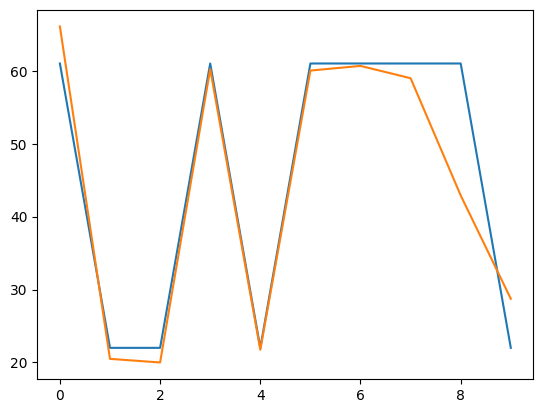

In [263]:
plt.plot(list(y_test))
plt.plot(prediction)

In [264]:
linear_mae = mean_absolute_error(list(y_test.values), list(prediction))

In [265]:
print(linear_mae)

3.776433729140917


In [266]:
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.05, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=5)

xgb_model.fit(X_train[feature].values,y_train)

intermediate_predictions = xgb_model.predict(X_test.values)
MAE = mean_absolute_error(list(y_test.values), list(intermediate_predictions))

In [267]:
X_test.values

array([[14.44601562, 47.73913043, 52.87107677],
       [24.25265625, 79.2       , 14.3584375 ],
       [24.13703125, 80.        , 15.571875  ],
       [13.23371094, 47.73913043, 20.88181895],
       [22.2715625 , 79.2       , 14.774375  ],
       [ 9.65632812, 49.90909091, 20.37182173],
       [ 8.67738281, 49.90909091, 20.66371626],
       [18.250625  , 45.75      , 19.31002604],
       [ 1.32066406, 70.        , 12.35574363],
       [ 8.7859375 , 80.        , 14.15104167]])

In [268]:
print(MAE)

2.3237159729003904


In [269]:
for i in zip(intermediate_predictions, y_test.values):
    print(i)

(60.956722, 61.0)
(22.525787, 22.0)
(22.525787, 22.0)
(60.956722, 61.0)
(22.525787, 22.0)
(68.62151, 61.0)
(68.62151, 61.0)
(60.956722, 61.0)
(57.648228, 61.0)
(24.935165, 22.0)


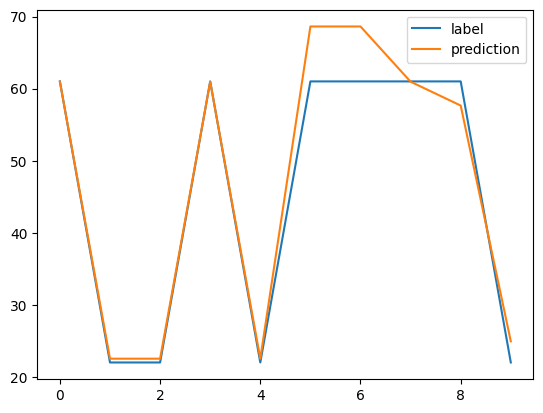

In [270]:
plt.plot(list(y_test.values), label="label")
plt.plot(list(intermediate_predictions), label="prediction")
plt.legend()

In [271]:
# 파일명
filename = 'xgb_regressor_100.model'

# 모델 저장
joblib.dump(xgb_model, open(filename, 'wb'))

xgb_model.save_model(filename)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:41:46] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
